In [1]:
'''
Create time series of the number of ERE in each region per day. 
Find the lead-lag correlation between two time series. 
'''

'\nCreate time series of the number of ERE in each region per day. \nFind the lead-lag correlation between two time series. \n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.signal import filtfilt, cheby1, butter, lombscargle, argrelmax, welch, periodogram
# from jams import lagcorr  # according to author's code
import pickle
from scipy.stats import pearsonr
import pandas as pd
import netCDF4 as nc
import pickle

In [3]:
def cheby_lowpass(cutoff, fs, order, rp):  
    # for chebyshev filter
    nyq = 0.5 * fs
    normal_cutoff = cutoff/ nyq
    b, a = cheby1(order, rp, normal_cutoff, btype = "low", analog = False)
    return b, a
'''
scipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.
fs: the sampling frequency of the digital system.
rp: the max ripple allowed below unity gain in the passband. 
'''

'\nscipy.signal.cheby1: Design an Nth-order digital/analog Chebyshev 1 I filter and return the filter coefficients.\nfs: the sampling frequency of the digital system.\nrp: the max ripple allowed below unity gain in the passband. \n'

In [4]:
def cheby_lowpass_filter(x, cutoff, fs, order, rp):
    # chebyshev filter: transform discrete values to a smooth curve
    b, a = cheby_lowpass(cutoff, fs, order ,rp)
    y = filtfilt(b, a, x)
    return y
'''
filtfilt: Apply a digital filter forward and backward to a signal.
'''

'\nfiltfilt: Apply a digital filter forward and backward to a signal.\n'

In [5]:
#try one file
nc_file = "D:/ic/urop/data/raw data/trmm_extra/20161108.nc4"
sigdata = nc.Dataset(nc_file)

lat = sigdata.variables['lat'][:]
lon = sigdata.variables['lon'][:]
#SCA
n25 = np.abs(lat - 25).argmin().item()
n32 = np.abs(lat - 32).argmin().item()
e71 = np.abs(lon - 71).argmin().item()
e88 = np.abs(lon - 88).argmin().item()
#EURO
n42 = np.abs(lat - 42).argmin().item()
n50 = np.abs(lat - 50).argmin().item()
e03 = np.abs(lon - 3).argmin().item()
e15 = np.abs(lon - 15).argmin().item()
print(n25, n32, e71, e88)

299 327 1003 1071


In [6]:

monsoon_indices = np.zeros(2, dtype = 'object')
list_asia = []
for i in range(e71, e88):
    for j in range(n25, n32):
        list_asia.append((i, j))  # include all nodes in SCA
        
list_eu = []
for i in range(e03, e15):
    for j in range(n42, n50):
        list_eu.append((i, j))  # include all nodes in EU

monsoon_indices[0] = np.array(list_asia)
monsoon_indices[1] = np.array(list_eu)

In [7]:
# define some parameters
monsoons = ['NISM','EUR']
syncs = ['ISM1-EUR']
sync_pairs = [[0, 1]]
taumax = 10
lag = range(-40, 41)

In [8]:
# import ERE date list, this include ERE all year long (instead of just JJA)
with open("ERE_start_all_days", "rb") as fp:   # Unpickling
    start_date_ERE = pickle.load(fp)

In [9]:
print(start_date_ERE[0][0])

[106, 111, 279, 470, 882, 982, 1094, 1438, 1625, 1995, 2173, 2223, 2230, 2245, 2249, 2271, 2346, 2360, 2640, 2728, 2979, 3223, 3243, 3392, 3743, 3778, 4038, 4070, 4086, 4146, 4182, 4362, 4368, 4383, 4528, 4729, 4743, 4765, 4784, 4841, 5096, 5166, 5360, 5454, 5571, 5765, 5848, 5870, 5896, 5948, 6183, 6601, 6643, 6779, 6886, 6892, 6918]


In [10]:
# need monsoon_ts
monsoon_ts = np.zeros((2, 6940))
for i in range(6940):
    for j in [0, 1]:
        num = 0
        for k in monsoon_indices[j]:
            if i in start_date_ERE[k[0]][k[1]]:
                num += 1
        monsoon_ts[j, i] = num

In [11]:
cutoff = 10
t1 = cheby_lowpass_filter(monsoon_ts[0], 0.95 * 1. / cutoff, 1, 8, .05)
t2 = cheby_lowpass_filter(monsoon_ts[1], 0.95 * 1. / cutoff, 1, 8, .05)

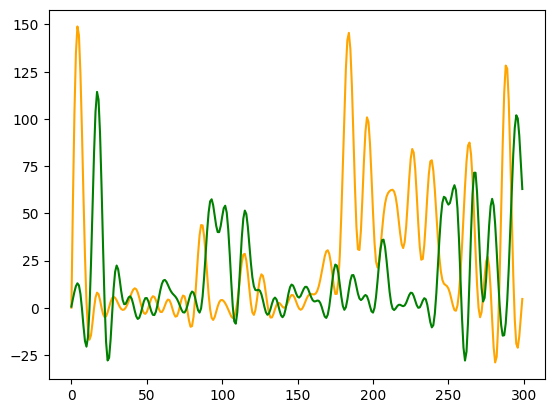

In [12]:
x_arr = np.arange(6940)
#plt.plot(x_arr[0:300], monsoon_ts[0][0:300],color = "red")
#plt.plot(x_arr[0:300], monsoon_ts[1][0:300], color = "blue")
plt.plot(x_arr[0:300], t1[0:300], color = "orange")
plt.plot(x_arr[0:300], t2[0:300], color = "green")

In [13]:
# Create a pandas DataFrame with the two time series
df = pd.DataFrame({'TimeSeries1': t1, 'TimeSeries2': t2})

# Calculate the correlation coefficient for each lag
max_lag = 365
lag = range(-max_lag, max_lag+1)
correlations = []
for l in range(-max_lag, max_lag + 1):
    df_shifted = df['TimeSeries2'].shift(l, fill_value=np.nan)
    # Drop rows with NaN values due to shifting
    df_combined = pd.concat([df['TimeSeries1'], df_shifted], axis=1).dropna()
    correlation_coefficient, p_value = pearsonr(df_combined['TimeSeries1'], df_combined['TimeSeries2'])
    correlations.append(correlation_coefficient)
best_lag = np.argmax(np.array(correlations))-max_lag
best_correlation = correlations[best_lag]

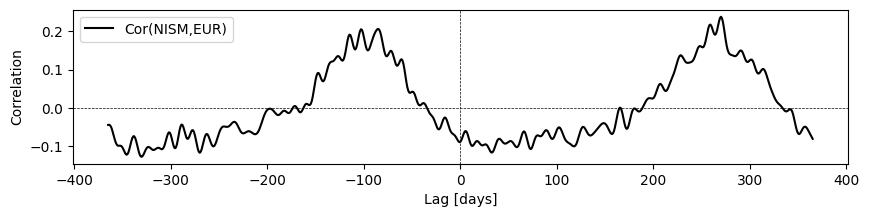

In [14]:
#plot
monsoons = ['NISM','EUR']
fig = plt.figure(figsize = (10, 2))
ax = fig.add_subplot(111)
ax.plot(lag, correlations, 'k-', label = 'Cor(%s,%s)'%(monsoons[0], monsoons[1]))
# ax.axvline(x = best_lag, color = 'k', lw = 2)
ax.axvline(x = 0, color = 'k', ls = '--', lw = .5)
ax.axhline(y = 0, color = 'k', ls = '--', lw = .5)
ax.set_ylabel(r'Correlation')
ax.set_xlabel('Lag [days]')
ax.set_ylabel('Correlation')
ax.legend(loc = 2)

In [15]:
# wrong covariance E[XY]
def cov_wrong(t1, t2, lag):
    n = len(t1) - abs(lag)
    sum = 0
    for i in range(n):
        sum += t1[i]* t2[i+lag]
    return sum/n
max_lag_w = 40
lag_w = range(-max_lag_w, max_lag_w + 1)
correlations_w = []
for l in range(-max_lag_w, max_lag_w + 1):
    cor_coeff = cov_wrong(t1, t2, l)
    correlations_w.append(cor_coeff)


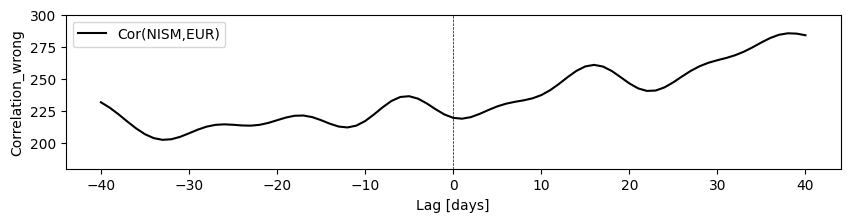

In [16]:
#plot
monsoons = ['NISM','EUR']

# correlations = [-1*i for i in correlations]

fig = plt.figure(figsize = (10, 2))
ax = fig.add_subplot(111)
ax.plot(lag_w, correlations_w, 'k-', label = 'Cor(%s,%s)'%(monsoons[0], monsoons[1]))
# ax.axvline(x = best_lag, color = 'k', lw = 2)
ax.axvline(x = 0, color = 'k', ls = '--', lw = .5)
ax.axhline(y = 0, color = 'k', ls = '--', lw = .5)
ax.set_ylim(180, 300)
ax.set_ylabel(r'Correlation_w')
ax.set_xlabel('Lag [days]')
ax.set_ylabel('Correlation_wrong')
ax.legend(loc = 2)